# Random Forest

What if instead of making one decision tree you made several. As many as you wanted, really. A whole forest. Then each tree in the forest got a vote on the outcome for a given observation. Then you'd have a new model type: **Random Forest**. Random forests have become an incredibly popular technique for data scientists because it tends to be a top performer in a huge number of circumstances, with low variance and high accuracy.

Much like Decision Trees, Random Forest can be used for both classification and regression problems. The main difference is how the votes are aggregated. As a classifier the most popular outcome (the mode) is returned. As a regression it is typically the average or mean that is returned.

#### Parameters

When building a Random Forest you get to set parameters for both the tree and the forest. So for the tree you have the same parameters as before: you can set the depth of the tree and the number of features used in each rule or split. You can also specify how the tree is built, with using information gain and entropy like we did before, or other methods like [Gini impurity](https://www.garysieling.com/blog/sklearn-gini-vs-entropy-criteria).

You also get to control the number of estimators you want to generate, or the number of trees in the forest. Here you have a tradeoff between how much variance you can explain and the computational complexity. This is pretty easily tuneable. As you increase the number of trees in the forest the accuracy should converge as eventually the additional learning from another tree approaches zero. There isn't an infinite amount of information to learn, and at some point the trees have learned all they can. So when you have acceptable variance in accuracy you can stop adding trees. This becomes worthwhile when you're dealing with large datasets with many variables.

#### Bagging and Random Subspace

Now, Random Forest models don't just create a ton of trees using the same data again and again and again. Instead they use bagging and random subspace to generate trees that are different. Without this, the trees could be incredibly similar (even identical), leading to correlation between trees and vulnerability to bias in the trees from some highly predictive features dominating every tree, creating a series of very similar trees with very similar, and potentially biased, predictions.

Firstly, Random Forests use **bagging**. Each tree selects a subset of observations with replacement to build the training set. Replacement here means it can simply choose the same observation multiple times, which is only really a problem when there are few observations. It puts the observation "back in the bag", if you will, where it can be pulled and chosen again.

Random forests also typically use a random subset of features for each split. This means for each time it has to perform a split or generate a rule, it is only looking at the **random subspace** created by a random subset of _some_ of the features as possibilities to generate that rule. This will help avoid the aforementioned correlation problem because the trees will not be built with the same available features at every point. As a general rule, for a dataset with x features $\sqrt{x}$ features are used for classifiers and $x/3$ for regression.

#### Advantages/Disadvantages to Random Forest
Advantages
- Strong performer in wide variety of situations
- Regression and classification possible

Disadvantages
- Can only output for predictions values which it has seen before from the training data
- Can be slow and cumbersome if it gets too big
- "Black box" complaint - you don't really know what's going on in the model and can't pinpoint its mechanisms

# Ensemble modeling
Random forest is an example of an ensemble model, which is a larger topic. An ensemble model is a model that is produced by, or made up of, other models. They build on simpler models into something that is usually more complex and therefore accurate. Though there are really infinite types of "ensemble" models, most fall into 3 categories:
- __Bagging:__ When you take subsets of data and train a model on each of the subsets, which then simultaneously vote on the outcome. The final output is then the majority or mean result.
- __Boosting:__ As opposed to building models simultaneously like bagging, boosting takes the output of one model as the input into the next in a form of *serial processing*. They then get chained together until the stopping condition is met (we'll cover this later).
- __Stacking:__ Stacking combines bagging and boosting by in phase one running a bagging exercise with simultaneous models, and then using those in phase two in a serial fashion.
- You can manually create ensemble models based on your own discretion as well.

#### Advantages/Disadvantages to Ensemble Modeling
There are advantages and disadvantages to ensemble models. Most notable is of course their performance. Ensemble models are often some of the most accurate techniques to apply to a problem. They also tend to have low variance because they're built from multiple internal models.

However there are also downsides. Most notably, some ensemble techniques, particularly boosting, are prone to overfitting. You also lose a lot of the transparency that individual models offer. You saw this clearly in the Random Forest example, where the easy explanations offered by decision trees are abstracted away by the forest.

# Random forest example

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [6]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.
y2015.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [4]:
# Importing the model
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

# Instantiating and fitting the model
rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)

cross_val_score(rfc, X, Y, cv=5)

MemoryError: 

Notice how the above causes an error. This is because get_dummies can be very memory intensive. Mixed data types worsen this because they all need to get converted to objects and have dummies created for them. So we could be dealing with a riduclous amount of individual values for certain vars. We need to clean up the categorical variables to continue (after restarting the kernel).

In [7]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

# Remove the two nans that are causing problems (summary rows)
y2015 = y2015[:-2]

Trying the model again if get_dummies is able to run...

In [8]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0,0,0,0,0,1,0,0,0,0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0,0,0,0,0,1,0,0,0,0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0,0,0,0,0,1,0,0,0,0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0,0,0,0,0,1,0,0,0,0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0,0,0,0,0,1,0,0,0,0
5,68506798.0,73396623.0,23000.0,23000.0,23000.0,8.49,471.77,64000.0,18.28,0.0,...,0,0,0,0,0,1,0,0,0,0
6,68566886.0,73456723.0,29900.0,29900.0,29900.0,12.88,678.49,65000.0,21.77,0.0,...,0,0,0,0,0,1,0,0,0,0
7,68577849.0,73467703.0,18000.0,18000.0,18000.0,11.99,400.31,112000.0,8.68,0.0,...,0,0,0,0,0,1,0,0,0,0
8,66310712.0,71035433.0,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,...,0,0,0,0,0,1,0,0,0,0
9,68476807.0,73366655.0,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,...,0,0,0,0,0,1,0,0,0,0


It does, so let's run the model. We'll drop NA columns since we have enough data to do without them.

In [9]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([ 0.97900786,  0.98052765,  0.98173874,  0.98188122,  0.97288055,
        0.97760627,  0.91225154,  0.98043174,  0.98002707,  0.98038284])

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

#### Drill Task:
Get rid of as much data as possible without dropping below an average 90% accuracy threshold. Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [29]:
for column in y2015.columns:
    print(column)

id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
pymnt_plan
purpose
title
dti
delinq_2yrs
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
next_pymnt_d
last_credit_pull_d
collections_12_mths_ex_med
mths_since_last_major_derog
policy_code
application_type
annual_inc_joint
dti_joint
verification_status_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_il_6m
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_

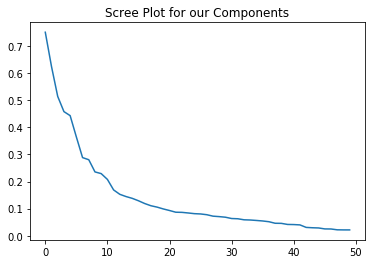

Percent of variance explained by component 
 [0.098517531850593504, 0.081910196511087149, 0.067433404191611215, 0.060088181901996114, 0.058140857069693408, 0.047829643916970206, 0.037817193095582055, 0.036791117085320117, 0.030886336213804502, 0.030067776712741592, 0.02725791590097576, 0.022161746560914942, 0.020034923310659428, 0.018956390941885101, 0.018087395323209823, 0.016920150815134573, 0.015584777516475754, 0.014514208903445023, 0.013842141294611667, 0.012956945538332704, 0.012200237277523025, 0.01137754983316318, 0.011303600702351261, 0.011010607792170748, 0.010677201913785858, 0.010532424305268039, 0.010167105221252276, 0.0094648858483957106, 0.0092423178548836828, 0.0089541246843559581, 0.0083213164286278837, 0.0082045916938455008, 0.007703166911428542, 0.0076003253674293957, 0.0073832947714728382, 0.0071351478940155626, 0.0067761712415522748, 0.0060283178930818646, 0.0059798954613939541, 0.0054551303744418637, 0.0053949164903167954, 0.00523218229903398, 0.004020620924443407

In [19]:
# Let's try PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

sklearn_pca = PCA(n_components=50)

pca_feat = X
X_normalized = MinMaxScaler().fit_transform(pca_feat)
X_PCA = sklearn_pca.fit_transform(X_normalized)
var_ratios = (list(sklearn_pca.explained_variance_ratio_))
component_variances = (list(sklearn_pca.explained_variance_))

# Performing a scree plot to decide which ones to keep
sorted_eigenvals = sorted(component_variances,reverse=True)
plt.plot(sorted_eigenvals)
plt.title("Scree Plot for our Components")
plt.show()

print('Percent of variance explained by component \n',var_ratios)
print('\n Eigenvalues: {}'.format(sorted_eigenvals))

We don't really have any eigenvalues greater than 1 since there are so many possible components, but there is a noticable elbow around 11 features. Let's use that as a cutoff and see what happens.

In [22]:
# Creating the corresponding DF
loan_pca = pd.DataFrame(X_PCA[:,0:12])
loan_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.043827,1.410839,0.434566,-0.284428,-0.075613,0.532055,0.814458,0.664567,-0.271422,0.594189,-0.539399,-0.443218
1,1.591305,0.172071,0.050847,-1.094789,-0.233112,0.294583,0.362144,0.116487,-0.351907,-0.587557,0.252175,-0.507553
2,-0.511938,0.048280,0.580181,-1.577001,-0.345916,0.106724,0.064425,-0.205648,-1.085612,0.166263,0.350212,0.335329
3,-0.414994,0.385717,-0.176522,-1.489528,-0.018490,0.149153,0.040018,-0.187123,-1.043280,0.194330,0.348397,0.257031
4,-0.701578,-0.815497,0.491692,0.034513,-1.229679,0.797127,-0.593949,-0.230786,0.267407,-0.115211,0.207035,-0.242126


In [25]:
# Running the model again
rfc = ensemble.RandomForestClassifier()
X = loan_pca
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([ 0.89739023,  0.90261452,  0.90137969,  0.91460663,  0.90289717,
        0.90745666,  0.91127787,  0.89878648,  0.90018287,  0.89543058])

Looks like this worked.

In [30]:
y2015['loan_status'].value_counts()

Current               287414
Fully Paid             87989
Charged Off            29178
Late (31-120 days)      9510
In Grace Period         4320
Late (16-30 days)       1888
Default                  796
Name: loan_status, dtype: int64